<a href="https://colab.research.google.com/github/SrivenkateswaraRao/Research-Project/blob/master/Pest_Classifier_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import keras
from keras.layers.core import Layer
import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [11]:
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten

import cv2 
import numpy as np 
from keras import backend as K 
from keras.utils import np_utils

import math 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler

In [14]:
models = tf.keras.models
layers = tf.keras.layers
initializers = tf.keras.initializers
regularizers = tf.keras.regularizers


In [15]:
def Xception(input_shape=(224,224,3), classes=10):
    """Instantiates the Xception architecture.
    """

    img_input = layers.Input(shape=input_shape)

    #===========ENTRY FLOW==============
    #Block 1
    x = conv_block(img_input, 32, block_num='1', conv_num='1', strides=(2,2))
    x = conv_block(x, 64, block_num='1', conv_num='2')

    #Block 2
    x = xception_block(x, (128, 128), '2', pre_activation=False)

    #Block 3
    x = xception_block(x, (256, 256), '3')

    #Block 4
    x = xception_block(x, (728, 728), '4')


    #===========MIDDLE FLOW===============
    for i in range(8):
        block_num = str(5+i)
        x = middle_flow_block(x, 728, block_num)

    #========EXIT FLOW============
    #Block 13
    x = xception_block(x, (728, 1024), '13') # second conv is different

    # Block 14
    x = separable_conv_block(x, 1536, block_num='14', conv_num='1', pre_activation=False)
    x = separable_conv_block(x, 2048, block_num='14', conv_num='2', pre_activation=False)

    # logistic regression
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(classes, activation='softmax', name='predictions')(x)

    # Create model.
    model = models.Model(inputs=img_input, outputs=x, name='xception')
    return model


In [17]:
def conv_block(x, filters, block_num, conv_num, strides=(1,1)):
    name = 'block{}_conv{}_'.format(block_num, conv_num)

    # conv-BN-relu
    x = layers.Conv2D(filters, (3,3), strides=(2,2), use_bias=False, name=name)(x)
    x = layers.BatchNormalization(name=name+'bn')(x)
    x = layers.Activation('relu', name=name+'act')(x)

    return x

In [20]:
def xception_block(x, filters, block_num, pre_activation=True):
    block = 'block{}_'.format(block_num)
    filter_conv1, filter_conv2 = filters

    # residual conv branch
    residual = layers.Conv2D(filter_conv2, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
    residual = layers.BatchNormalization()(residual)

    # separable conv block
    x = separable_conv_block(x, filter_conv1, block_num=block_num, conv_num='1', pre_activation=pre_activation)
    x = separable_conv_block(x, filter_conv2, block_num=block_num, conv_num='2', pre_activation=True)

    # downsampling and merging
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name=block+'pool')(x)

    return layers.add([x, residual])

In [22]:
def separable_conv_block(x, filters, block_num, conv_num, pre_activation=None):
    name = 'block{}_sepconv{}_'.format(block_num, conv_num)

    if pre_activation is True:
        x = layers.Activation('relu', name=name+'act')(x)

    # (relu)-sepconv-BN-(relu)
    x = layers.SeparableConv2D(filters, (3,3), padding='same', use_bias=False, name=name)(x)
    x = layers.BatchNormalization(name=name+'bn')(x)

    if pre_activation is False:
        x = layers.Activation('relu', name=name+'act')(x)


    return x

In [28]:
def middle_flow_block(x, filters, block_num):
    residual = x
    x = separable_conv_block(x, filters, block_num=block_num, conv_num='1', pre_activation=True)
    x = separable_conv_block(x, filters, block_num=block_num, conv_num='2', pre_activation=True)
    x = separable_conv_block(x, filters, block_num=block_num, conv_num='3', pre_activation=True)

    return layers.add([x, residual])

In [29]:
model =  Xception()
model.summary()


Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1_ (Conv2D)          (None, 111, 111, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1_[0][0]              
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [30]:
import os
from os import listdir
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np

In [31]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [32]:
file_list = drive.ListFile(
    {'q': "'1MzurTS9xeNSss_hYgko4ATZ5qNVn45ty' in parents"}).GetList()

for f in file_list:
    print('title: %s, id: %s' % (f['title'], f['id']))
    fname = f['title']
    print('downloading to {}'.format(fname))
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)

title: LABELS.zip, id: 1dYxm-yV2sCOxiQQSvzRY6-gKtlfo0WLH
downloading to LABELS.zip
title: GREENPATROL_DB_V1.0.zip, id: 1wJw1Ci1OTUoKjiiT3lwWqwonTunGPMB1
downloading to GREENPATROL_DB_V1.0.zip
title: predefined_classes.txt, id: 1XQkqHvepaPEXxJ5XXSZmMMk9qrxTOSzJ
downloading to predefined_classes.txt


In [33]:
#------------------------------- Load Train Data ----------------------------------------------#
download_Pests = drive.CreateFile({'id': '1wJw1Ci1OTUoKjiiT3lwWqwonTunGPMB1'})
download_Annotations = drive.CreateFile({'id': '1dYxm-yV2sCOxiQQSvzRY6-gKtlfo0WLH'})
!unzip LABELS.zip -d '/Tomato-Pests'
!unzip GREENPATROL_DB_V1.0.zip -d '/Tomato-Pests'


Archive:  LABELS.zip
  inflating: /Tomato-Pests/LABELS/1_2_2_6_1_1_20180622-102849.xml  
  inflating: /Tomato-Pests/LABELS/1_2_2_6_1_1_20180622-102918.xml  
  inflating: /Tomato-Pests/LABELS/1_2_2_6_1_1_20180622-110731.xml  
  inflating: /Tomato-Pests/LABELS/1_2_2_6_1_1_20180622-110804.xml  
  inflating: /Tomato-Pests/LABELS/1_2_2_6_1_1_20180622-110827.xml  
  inflating: /Tomato-Pests/LABELS/1_2_2_6_1_1_20180622-110905.xml  
  inflating: /Tomato-Pests/LABELS/1_2_2_6_1_1_20180622-110931.xml  
  inflating: /Tomato-Pests/LABELS/1_2_2_6_1_1_20180622-111004.xml  
  inflating: /Tomato-Pests/LABELS/1_2_2_6_1_1_20180622-111118.xml  
Archive:  GREENPATROL_DB_V1.0.zip
  inflating: /Tomato-Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180622-102849.jpg  
  inflating: /Tomato-Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180622-102918.jpg  
  inflating: /Tomato-Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180622-110731.jpg  
  inflating: /Tomato-Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180622-110804.jpg  
  inflati

In [34]:
from google.colab import files
files.upload() 

Saving CreatePestImageData_GoogleNet.py to CreatePestImageData_GoogleNet.py


{'CreatePestImageData_GoogleNet.py': b'# -*- coding: utf-8 -*-\r\n"""createImageDataset.ipynb\r\n\r\nAutomatically generated by Colaboratory.\r\n\r\nOriginal file is located at\r\n    https://colab.research.google.com/drive/1FXiYKCQ-jtbL_O29BQb2Xy1bBd2inM9q\r\n"""\r\n\r\nfrom os import listdir\r\nimport numpy as np\r\nimport xml.etree.ElementTree as ET\r\nimport cv2\r\nimport tensorflow as tf \r\n\r\nclass createImageDataset(object):\r\n    \r\n    def __init__(self, class_map=None):\r\n        self.image_info = []\r\n        self.trainX = []\r\n        self.trainY = []\r\n        self.testX = []\r\n        self.testY = []\r\n            \r\n    def add_image_info(self , image_array , image_path , image_id , object_id , class_name , class_id):\r\n        \r\n        image_info_ = {\'object_id\': image_id,\r\n                       \'object_class\': class_name,\r\n                       \'image_path\': image_path,\r\n                       \'image_array\': image_array,\r\n              

In [35]:
import CreatePestImageData_GoogleNet as Imagedataset

In [36]:
dataSet = Imagedataset.createImageDataset()

In [37]:
class_object = {0 : 'egg_wf' ,
                1 : 'egg_bt', 2 : 'egg_ta', 3 : 'wf', 4 : 'bt', 5 : 'ta', 6 : 'ta_maps', 7 : 'ta_larvae', 8 : 'ta_maps+larvae', 9 : 'tomato'}

In [38]:
 dataSet.prepare_dataset('/Tomato-Pests/LABELS/' , class_object , '/Tomato-Pests/GREENPATROL_DB_V1.0/',  test_size=5 )

Image : /mendelu_pictures/pictures/2018-06-22 IMAGING JAI CMOS/1_2_2_6_1_1_20180622-110931.jpg added to dataset with class name "bt".
Image : /mendelu_pictures/pictures/2018-06-22 IMAGING JAI CMOS/1_2_2_6_1_1_20180622-110931.jpg added to dataset with class name "bt".
Image : /mendelu_pictures/pictures/2018-06-22 IMAGING JAI CMOS/1_2_2_6_1_1_20180622-110931.jpg added to dataset with class name "bt".
Image : /mendelu_pictures/pictures/2018-06-22 IMAGING JAI CMOS/1_2_2_6_1_1_20180622-110931.jpg added to dataset with class name "bt".
Image : /mendelu_pictures/pictures/2018-06-22 IMAGING JAI CMOS/1_2_2_6_1_1_20180622-110931.jpg added to dataset with class name "bt".
Image : /mendelu_pictures/pictures/2018-06-22 IMAGING JAI CMOS/1_2_2_6_1_1_20180622-110931.jpg added to dataset with class name "bt".
Image : /mendelu_pictures/pictures/2018-06-22 IMAGING JAI CMOS/1_2_2_6_1_1_20180622-110931.jpg added to dataset with class name "bt".
Image : /mendelu_pictures/pictures/2018-06-22 IMAGING JAI CMOS

In [39]:
(trainY , trainX) , (testY , testX ) = (dataSet.trainY , dataSet.trainX ) , (dataSet.testY , dataSet.testX )


In [49]:
epochs = 25
model.compile(loss='mse', optimizer='adam', metrics ='accuracy')

history = model.fit(trainX, trainY, epochs=epochs)


Epoch 1/25
3/3 [==============================] - 8s 3s/step - loss: 9.7336 - accuracy: 0.2537
Epoch 2/25
3/3 [==============================] - 9s 3s/step - loss: 9.7312 - accuracy: 0.1194
Epoch 3/25
3/3 [==============================] - 8s 3s/step - loss: 9.7309 - accuracy: 0.3284
Epoch 4/25
3/3 [==============================] - 8s 3s/step - loss: 9.7309 - accuracy: 0.0000e+00
Epoch 5/25
3/3 [==============================] - 8s 3s/step - loss: 9.7308 - accuracy: 0.5522
Epoch 6/25
3/3 [==============================] - 8s 3s/step - loss: 9.7306 - accuracy: 0.0149
Epoch 7/25
3/3 [==============================] - 8s 3s/step - loss: 9.7306 - accuracy: 0.1493
Epoch 8/25
3/3 [==============================] - 8s 3s/step - loss: 9.7306 - accuracy: 0.2836
Epoch 9/25
3/3 [==============================] - 8s 3s/step - loss: 9.7306 - accuracy: 0.0000e+00
Epoch 10/25
3/3 [==============================] - 8s 3s/step - loss: 9.7306 - accuracy: 0.1493
Epoch 11/25
3/3 [========================

In [ ]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(67, 224, 224, 3)
(67,)
(5, 224, 224, 3)
(5,)


In [50]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
   
  plt.imshow(img[...,0], cmap=plt.cm.binary)
 
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
   
  plt.xlabel("{} {:2.0f}% ({})".format(class_object[predicted_label],
                                100*np.max(predictions_array),
                                class_object[true_label]),
                                color=color)


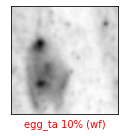

In [51]:
num_rows = 1
num_cols = 1
num_images = num_rows*num_cols
plt.figure(figsize=(2*num_cols, 2*num_rows))
test_images = testX[:num_images]
predictions = model.predict(testX)
for i in range(num_images):    
    plt.subplot(num_rows, num_cols, i+1)   
    plot_image(i, predictions, testY, testX)    
 
plt.tight_layout()
plt.show()